In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')  

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import Series, DataFrame
import pytz
from pytz import common_timezones, all_timezones
import matplotlib
matplotlib.style.use('ggplot')
%matplotlib inline
from datetime import datetime
import scipy as sp
import statsmodels.api as sm
import statsmodels.formula.api as smf
matplotlib.style.use('fivethirtyeight')
matplotlib.style.use('seaborn-talk')
import os
import collections

preDouble = "\\\\iobsdc01\\SharedDocs\\SEER_MEDICARE\\SEER_MEDICARE_STAGING"
new = os.chdir(preDouble)
#print(preDouble)

In [3]:
df = pd.read_pickle('dfpedsfFirsts.pickle')

# <font color='#E56717'>SEER-Medicare Data Files</font>


* <span style="font-size:1.5em;">Patient Entitlement and Diagnosis Summary File (PEDSF)</span>
* <span style="font-size:1.5em;">Medicare Provider Analysis and Review (MEDPAR)</span>
*  <span style="font-size:1.5em;">Carrier Claims (old file name Physician/Supplier Part B (NCH))</span>
*  <span style="font-size:1.5em;">Outpatient Claims</span>
*  <span style="font-size:1.5em;">Home Health Agency (HAA)</span>
*  <span style="font-size:1.5em;">Hospice</span>
*  <span style="font-size:1.5em;">Durable Medical Equipment (DME)</span>
*  <span style="font-size:1.5em;">Medicare Part D Data</span>

In [15]:
papaya = '#E56717'

# <font color='#E56717'>First order of business is to identify all the patients in the SEER-Medicare data who have received PBT</font>



<span style="font-size:1.5em;">The relevant HCPCS are:</span>

* <span style="font-size:1.5em;">77520 - Proton trmt simple w/o comp</span>
* <span style="font-size:1.5em;">77522 - Proton trmt simple w/comp</span>
* <span style="font-size:1.5em;">77523 - Proton trmt intermediate</span>
* <span style="font-size:1.5em;">77525 - Proton treatment complex</span>

<span style="font-size:1.5em;">as well as the HCPCS code S8030 (Scleral application of tantalum ring(s) for localization of lesions for proton beam therapy)</span>

# <font color='#E56717'>Use the Outpatient Claims and Carrier Claims files</font>


* <span style="font-size:1.5em;">218 Outpatient Claims files</span>
* <span style="font-size:1.5em;">207 Carrier Claims files</span>


<span style="font-size:1.5em;">Loop through all of these files and capture the set of all the</span> <span style="font-size:1.5em;font-family:Consolas,Monaco;">patient_id</span> <span style="font-size:1.5em;">s corresponding to the PBT HCPCS codes</span>

<span style="font-size:1.8em;">**Result: 1584 unique PBT patients appear in the claims files for claims in years 2006-2013**</span>


In [4]:
mask = (df['srvm1'] != 9999)
dfall = df[mask]

In [5]:
geomask = (dfall['elevation_1'] != dfall['FIPScombo_1']) 

dfall = dfall[geomask].copy()

In [6]:
dfall['elevation_1'].replace('99999',np.nan,inplace=True)
dfall['elevation_2'].replace('99999',np.nan,inplace=True)
dfall['elevation_3'].replace('99999',np.nan,inplace=True)

dfall['lat_1'].replace('99999',np.nan,inplace=True)
dfall['lat_2'].replace('99999',np.nan,inplace=True)
dfall['lat_3'].replace('99999',np.nan,inplace=True)

dfall['lng_1'].replace('99999',np.nan,inplace=True)
dfall['lng_2'].replace('99999',np.nan,inplace=True)
dfall['lng_3'].replace('99999',np.nan,inplace=True)

dfall['elevation_1'] = dfall['elevation_1'].astype('float')
dfall['elevation_2'] = dfall['elevation_2'].astype('float')
dfall['elevation_3'] = dfall['elevation_3'].astype('float')

dfall['lat_1'] = dfall['lat_1'].astype('float')
dfall['lat_2'] = dfall['lat_2'].astype('float')
dfall['lat_3'] = dfall['lat_3'].astype('float')

dfall['lng_1'] = dfall['lng_1'].astype('float')
dfall['lng_2'] = dfall['lng_2'].astype('float')
dfall['lng_3'] = dfall['lng_3'].astype('float')

In [7]:
import pickle
fileObject = open('patient_ids_from_outsaf.pickle', 'rb')
b = pickle.load(fileObject)
fileObject.close()
treatmentindices_outsaf = list(set.union(*b))

In [8]:
import pickle
fileObject = open('patient_ids_from_nch.pickle', 'rb')
b = pickle.load(fileObject)
fileObject.close()
treatmentindices_nch = list(set.union(*b))

In [9]:
bigtreatmentindices = list(set(treatmentindices_nch+treatmentindices_outsaf))

dfall.set_index('patient_id', inplace=True,drop=False)

allindices = dfall.index

In [10]:
bigtreatmentset = set(bigtreatmentindices)
allset = set(allindices)


alltreatmentindices = list(allset.intersection(bigtreatmentset))

treatmentindices = alltreatmentindices
#len(treatmentindices)

# <font color='#E56717'>Now use the pedsf files to perform patient matching, using the <span style="font-family:Consolas;">patient_id</span> s found above</font>

<span style="font-size:1.5em;">List of pedsf files (contains SEER cases for diagnosis year dates 2006-2011):</span>

* <span style="font-size:1.3em;">pedsf.nasopharynx.cancer.txt</span>
* <span style="font-size:1.3em;">pedsf.salivarygland.cancer.txt</span>
* <span style="font-size:1.3em;">pedsf.oropharynx.cancer.txt</span>
* <span style="font-size:1.3em;">pedsf.esophagus.cancer.txt</span>
* <span style="font-size:1.3em;">pedsf.brain.cancer.txt</span>
* <span style="font-size:1.3em;">pedsf.eyeandorbit.cancer.txt</span>
* <span style="font-size:1.3em;">pedsf.softtissue.cancer.txt</span>
* <span style="font-size:1.3em;">pedsf.prostate.cancer.file01.txt</span>
* <span style="font-size:1.3em;">pedsf.prostate.cancer.file02.txt</span>
* <span style="font-size:1.3em;">pedsf.prostate.cancer.file03.txt</span>
* <span style="font-size:1.3em;">pedsf.lung.cancer.file01.txt</span>
* <span style="font-size:1.3em;">pedsf.lung.cancer.file02.txt</span>



# <font color='E56717'>The pedsf files contain one single row for each patient, and contain the information for up to 10 different primary tumors</font>

<span style="font-size:1.5em;">So the prostate cancer files contain all patients with a cancer diagnosis where the primary site is the prostate for ANY of the potentially 10 different primary tumors associated with that patient and where that prostate site tumor has a diagnosis date anywhere between 2006 and 2011.</span>

 

In [11]:
import pedsfhelp

df2 = pedsfhelp.make_clean_dataframe('pedsf.salivarygland.cancer.txt')
#print(df2.shape)

<span style="font-size:1.5em;">For example, in the  file pedsf.salivarygland.cancer.txt, the cancer sites for the first tumor listed for each patient has the following distribution:</span>

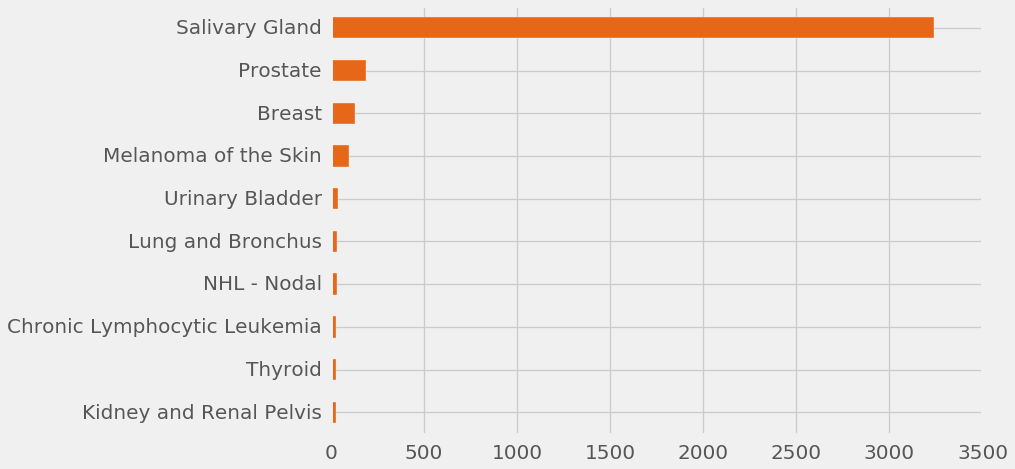

In [18]:
df2.siterwho1.value_counts()[:10][::-1].plot(kind='barh',
                                            color='#E56717');
plt.tick_params(labelsize=20)

## <font color="E56717">Only keep those patients whose first tumor is at the site indicated in the corresponding file</font>

<span style="font-size:1.5em;">This way we avoid the complications other than the cancer under consideration that may be contributing factors to the outcomes we are analyzing.</span>

<span style="font-size:1.5em;">Also restrict the analysis to those patients who received some form of radiation treatment for this first diagnosis</span>


<span style="font-size:1.5em;">These restrictions bring down the number of patients under consideration in the concatenated pedsf file: 502438 down to 180121</span>

<span style="font-size:1.5em;">Also brings down the number of PBT patients under consideration: 1584 down to 1190</span>

In [21]:
dfall.patient_id.isin(treatmentindices).sum()

1584

In [22]:
dfall.shape

(502438, 496)

In [23]:
non_rad1 = dfall.rad1.str.contains('None',case=False,na=False)
refused_rad1 = dfall.rad1.str.contains('refused',case=False,na=False)
unknown_rad1 = dfall.rad1.str.contains('unknown',case=False,na=False)

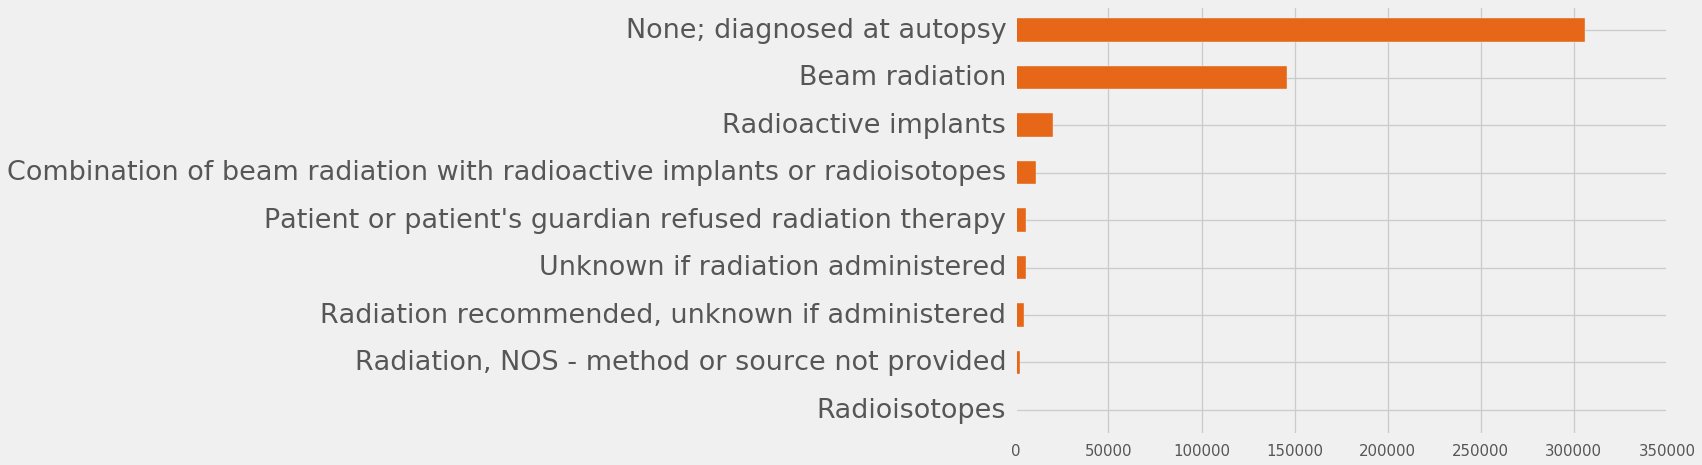

In [49]:
import mpld3
mpld3.disable_notebook()
ax = dfall.rad1.value_counts()[::-1].plot(kind='barh',color='#E56717')
ax.yaxis.set_tick_params(labelsize=27)
ax.xaxis.set_tick_params(labelsize=15)
#plt.tick_params(labelsize=27) # remove the None, refused and unknown group

In [30]:

one = ~non_rad1 & ~refused_rad1 & ~unknown_rad1

had_rad = one

dfsmall = dfall[had_rad].copy()


In [31]:
dfsmall.shape

(180121, 496)

In [42]:
smalltreatmentindices = dfsmall[dfsmall.patient_id.isin(treatmentindices)].index
smallcontrolindices = dfsmall[~dfsmall.patient_id.isin(treatmentindices)].index


In [44]:
smallcontrolindices.shape;

In [46]:
smalltreatmentindices.shape;

In [47]:
dfalltreatment = dfsmall.loc[smalltreatmentindices].copy()
dfallcontrol = dfsmall.loc[smallcontrolindices].copy()


# <font color='#E56717'>So we are going to match patients who have received PBT (1190 of them) with one of the 178931 patients who have received some other form of radiation</font>

<span style="font-size:1.5em;">We first need to decide on which features (or columns) of the data to use to define the feature space; and then do some preprocessing of this data ("one-hot-encode" the categorical features)</span>

In [50]:
dfsmall.columns

Index(['casereg', 'patient_id', 'casenumber', 'fivepct', 'medicaredateofdeath',
       'birthm', 'birthyr', 'm_sex', 'race', 'state',
       ...
       'icdot09_1_description', 'icdot09_2_description',
       'icdot09_3_description', 'icdot09_4_description',
       'icdot09_5_description', 'icdot09_6_description',
       'icdot09_7_description', 'icdot09_8_description',
       'icdot09_9_description', 'icdot09_10_description'],
      dtype='object', length=496)

In [51]:
cstum1mask =  (dfsmall['cstum1'] != "Unknown; size not stated; not stated in patient record") & \
(dfsmall['cstum1'] != "Microscopic focus or foci only; no size of focus is given") & \
(dfsmall['cstum1'] != "989 millimeters or larger") & \
(dfsmall['cstum1'] != "Not applicable") & \
(dfsmall['cstum1'] != "Unknown age") & \
(dfsmall['cstum1'] != "Described as less than 1 cm") & \
(dfsmall['cstum1'] != "Described as less than 2 cm") & \
(dfsmall['cstum1'] != "Described as less than 3 cm") & \
(dfsmall['cstum1'] != 'Indicates no mass or no tumor found; for example, when a tumor of a stated primary site is not found, but the tumor has metastasized') & \
(dfsmall['cstum1'] != "Described as less than 4 cm") & \
(dfsmall['cstum1'] != "Described as less than 5 cm") & \
(dfsmall['cstum1'] != "Not applicable") & \
(dfsmall['cstum1'] != 'Not applicable') & \
(dfsmall['cstum1'] != 996) & \
(dfsmall['cstum1'] != 997) & \
(dfsmall['cstum1'] != 998) & \
(dfsmall['srvm1'] != 9999)

# <font color="#E56717">We will not include the variable **cstum1** (the tumor size in mm) for the following reasons:</font>

* <span style="font-size:1.5em;">Egregious measurement error, plots to follow for lung and prostate</span>
* <span style="font-size:1.5em;">Over half of the patients have missing values, or text values instead of numbers</span>
    * "Unknown; size not stated; not stated in patient record"
    * "Microscopic focus or foci only; no size of focus is given"
    * "989 millimeters or larger"
    * "Not applicable"
    * "Described as less than 1 cm"
    * "Described as less than 2 cm"
    * "Described as less than 3 cm"
    * 'Indicates no mass or no tumor found; for example, when a tumor of a stated primary site is not found, but the tumor has metastasized'
    * "Described as less than 4 cm"
    * "Described as less than 5 cm"


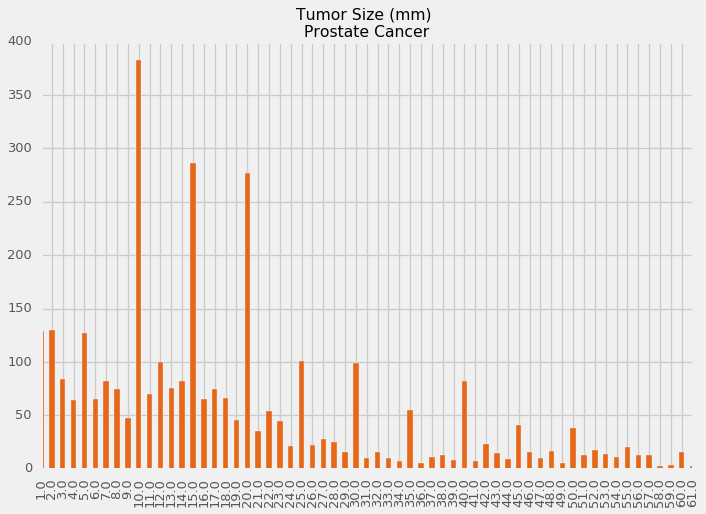

In [81]:
dfsmall[cstum1mask & dfsmall.siterwho1.str.contains("prostate",case=False,na=False)].cstum1.value_counts().sort_index().plot(kind='bar',
            title='Tumor Size (mm) \nProstate Cancer',color='#E56717');
plt.xlim(0,60);

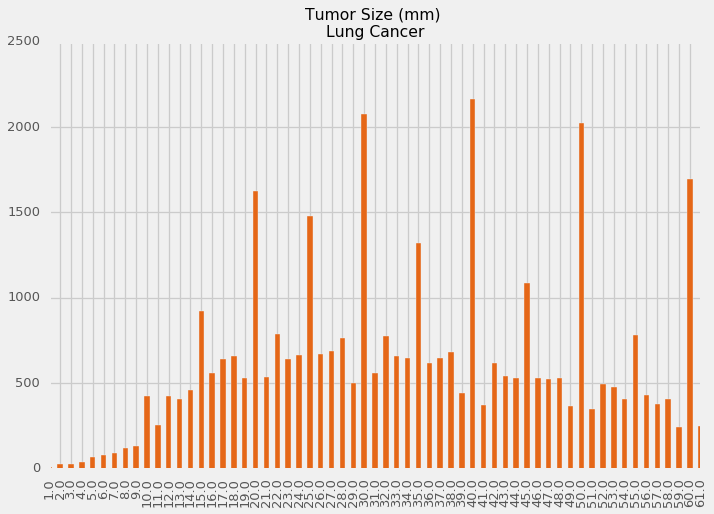

In [83]:
fig1 = plt.figure()
ax = dfsmall[cstum1mask & dfsmall.siterwho1.str.contains("lung",case=False,na=False)].cstum1.value_counts().sort_index().plot(kind='bar',
            title='Tumor Size (mm) \nLung Cancer',color='#E56717');
plt.xlim(0,60);

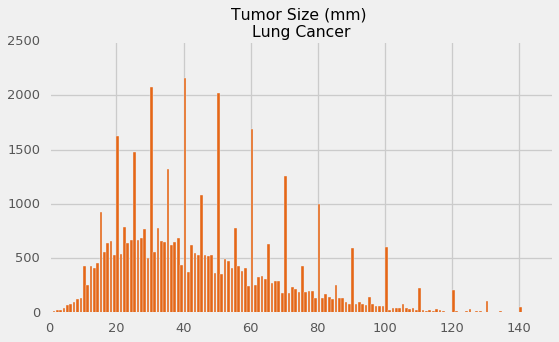

In [97]:
import mpld3
fig, ax = plt.subplots(figsize=(8,5))
huh = dfsmall[cstum1mask & dfsmall.siterwho1.str.contains("lung",case=False,na=False)].cstum1.value_counts().sort_index()
xvalues = huh.index
yvalues = huh.values

rects = ax.bar(xvalues,yvalues,color='#E56717')
plt.xlim(0,150)
plt.title('Tumor Size (mm) \nLung Cancer')
plt.tight_layout()
plt.show()


In [98]:

mpld3.disable_notebook()
mpld3.display(fig)

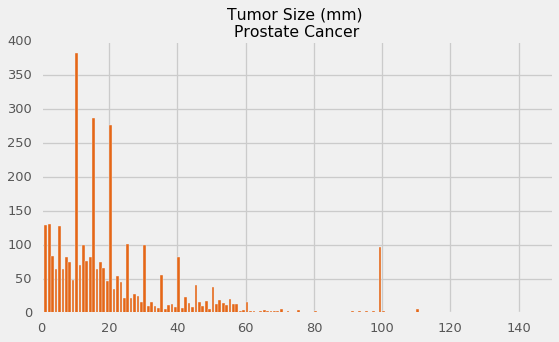

In [100]:
figp, ax = plt.subplots(figsize=(8,5))
huh = dfsmall[cstum1mask & dfsmall.siterwho1.str.contains("prostate",case=False,na=False)].cstum1.value_counts().sort_index()
xvalues = huh.index
yvalues = huh.values

rects = ax.bar(xvalues,yvalues,color='#E56717')
plt.xlim(0,150)
plt.title("Tumor Size (mm) \nProstate Cancer")
plt.tight_layout()
plt.show()


In [101]:
mpld3.display(figp)

In [104]:
catcols = ['m_sex','marst1','srace','nhiade','grade1',
           'site1',
          'histrec1',
           'modx1','stat_rec']


goodcols = ['m_sex','marst1', 'srace','nhiade',
           'grade1','site1',
           'lat1','histrec1',
           'modx1','stat_rec','birthyr',
           'agedx1',
           'yrdx1','elevation_1',
           'lng_1']



In [103]:
dfpop = pd.concat([dfallcontrol, dfalltreatment])

In [105]:
resgoodcontrol = pd.concat([pd.get_dummies(dfallcontrol[col],prefix=col) for col in catcols], axis=1)

resgoodtreatment = pd.concat([pd.get_dummies(dfalltreatment[col],prefix=col) for col in catcols], axis=1)

resgoodpop = pd.concat([pd.get_dummies(dfpop[col],prefix=col) for col in catcols], axis=1)

In [106]:
print(goodcols)

['m_sex', 'marst1', 'srace', 'nhiade', 'grade1', 'site1', 'lat1', 'histrec1', 'modx1', 'stat_rec', 'birthyr', 'agedx1', 'yrdx1', 'elevation_1', 'lng_1']


In [107]:
resgoodcontrol['birthyr'] = dfallcontrol['birthyr']
resgoodcontrol['agedx1'] = dfallcontrol['agedx1']

resgoodcontrol['yrdx1'] = dfallcontrol['yrdx1']

resgoodcontrol['lat_1'] = dfallcontrol['lat_1']

resgoodcontrol['lng_1'] = dfallcontrol['lng_1']

resgoodcontrol['srvm1'] = dfallcontrol['srvm1']

resgoodcontrol['elevation_1'] = dfallcontrol['elevation_1']

In [108]:
resgoodtreatment['birthyr'] = dfalltreatment['birthyr']
resgoodtreatment['agedx1'] = dfalltreatment['agedx1']

resgoodtreatment['yrdx1'] = dfalltreatment['yrdx1']



resgoodtreatment['lat_1'] = dfalltreatment['lat_1']

resgoodtreatment['lng_1'] = dfalltreatment['lng_1']

resgoodtreatment['srvm1'] = dfalltreatment['srvm1']

resgoodtreatment['elevation_1'] = dfalltreatment['elevation_1']

In [109]:
resgoodpop['birthyr'] = dfpop['birthyr']
resgoodpop['agedx1'] = dfpop['agedx1']

resgoodpop['yrdx1'] = dfpop['yrdx1']




resgoodpop['lat_1'] = dfpop['lat_1']

resgoodpop['lng_1'] = dfpop['lng_1']

resgoodpop['srvm1'] = dfpop['srvm1']

resgoodpop['elevation_1'] = dfpop['elevation_1']

# <font color="#E56717">After performing the matching bewteen the control and treatment groups, we can see how the Kaplan-Meier curves differ</font>

<span style="font-size:1.5em;">Below is how it looks before matching patients in the control and treatment groups together in pairs</span>

In [110]:
from lifelines import KaplanMeierFitter

kmfpop = KaplanMeierFitter()
kmfcontrol = KaplanMeierFitter()
kmftreatment = KaplanMeierFitter()

Tcontrol = resgoodpop.loc[smallcontrolindices]["srvm1"]
Econtrol = resgoodpop.loc[smallcontrolindices]["stat_rec_Dead"]

Ttreatment = resgoodpop.loc[smalltreatmentindices]["srvm1"]
Etreatment = resgoodpop.loc[smalltreatmentindices]["stat_rec_Dead"]

Tpop = resgoodpop["srvm1"]
Epop = resgoodpop["stat_rec_Dead"]

kmfpop.fit(Tpop, event_observed=Epop,label='All Radiation group');
kmfcontrol.fit(Tcontrol, event_observed=Econtrol,label='Non PT group (control group)')
kmftreatment.fit(Ttreatment, event_observed=Etreatment, label='PT group (treatment group)')

<lifelines.KaplanMeierFitter: fitted with 1190 observations, 1042 censored>

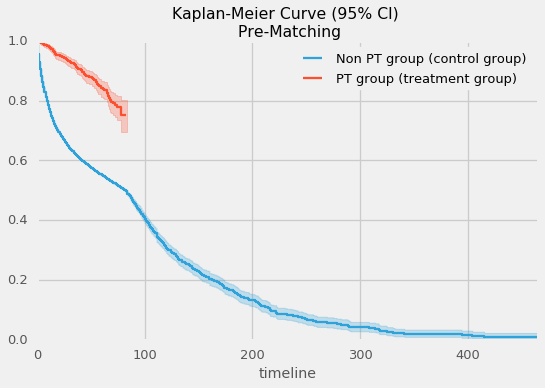

In [112]:
mpld3.enable_notebook()
ax = kmfcontrol.plot(figsize=(8,5))
kmftreatment.plot(ax=ax)
plt.title("Kaplan-Meier Curve (95% CI) \n Pre-Matching");